In [2]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.trainers as tr
import src.logconfig as logconfig
import logging
logconfig.setup_logging(console_level=logging.INFO)

In [3]:
read_features_targets_kwargs = {'fields_to_read' :    {"B": True,"B_ext": False,"divB": False,"E": True,"E_ext": False,"rho": True,"J": True,
                                                      "P": True,"PI": True,"Heat_flux": False,"N": False,"Qrem": False}, # which fields to read
                                'request_features' :  ['rho_e', 'Bx', 'By', 'Bz', 'Vx_e', 'Vy_e', 'Vz_e', 'Ex', 'Ey', 'Ez'],  # what network needs to make predictions
                                'request_targets' :   ["Pxx_e", "Pyy_e","Pzz_e","Pxy_e","Pxz_e","Pyz_e"],                     # what we want to predict
                                'choose_species' :    ['e',None],   # which species to take
                                'choose_x' : [0,256], 'choose_y' : [0,256], 'verbose' : False  # which part of the domain to take. The full domain is 2048x2048 and is too heavy for the tutorial
                          } # make sure not to put a comma here, otherwise the object becomes a tuple rather than a dictionary which causes all sorts of problems

In [4]:
dataset_kwargs = {'data_folder': "/volume1/scratch/share_dir/ecsim/",               # where the data is stored
                          'image_file_name_column' : 'filenames',                       # the column in the csv file that contains the image file names
                          'read_features_targets_kwargs' : read_features_targets_kwargs,
                          'train_sample' :  "/volume1/scratch/share_dir/brecht/sampling/turbulence/train.csv",  # this should be the path to the csv file that contains a list of training samples, each cell corresponds to local paths to the actual data relative to `data_folder`
                          'val_sample' :    "/volume1/scratch/share_dir/brecht/sampling/turbulence/val.csv",    # same but validation
                          'test_sample' :   "/volume1/scratch/share_dir/brecht/sampling/turbulence/test.csv",   # same but testing
                          'scaler_features' : True,    # Whether to normalize the features. It is called scaler because it rescales to 0 mean and 1 variance
                          'scaler_targets' : True,     # Whether to normalize the targets
                          'prescaler_targets' : ['log','log','log',None,None,None]  # If we want to transform the targets before training. The order in which they appear correspond to `request_targets` in `read_features_targets_kwargs``
                      }

In [5]:
import pandas as pd
pd.read_csv(dataset_kwargs['test_sample'])

,filenames
0,peppe/data/MSH-Fields_006000.h5
1,peppe/data/MSH-Fields_006500.h5
2,peppe/data/MSH-Fields_007000.h5
3,peppe/data/MSH-Fields_007500.h5
4,peppe/data/MSH-Fields_014000.h5
5,peppe/data/MSH-Fields_014500.h5
6,peppe/data/MSH-Fields_015000.h5


In [6]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : .2,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : .2, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

In [7]:
model_kwargs={'model': 'MLP',    # the model class name we want to use, check `src/models.py` for available models
              'model_seed' : 42, # seed for the random initialization of the model
              'feature_dims' : [10, 60, 80, 50, 40, 6], # the dimensions of the layers in the model. The first element should be the number of `request_features` in `read_features_targets_kwargs` and the last element should be the number of `request_targets` in `read_features_targets_kwargs`
              'activations' : ['Tanh','Tanh','ReLU','Tanh', None], 
    'optimizer_kwargs': {'optimizer' : 'Adam',      # look up https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam 
                         'lr' : 5e-4,               # learning rate
                         'criterion': 'MSELoss'},   # the loss function to optimize
    'scheduler_kwargs': {'scheduler' : 'ReduceLROnPlateau',  # look up https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
                         'mode' : 'min',  # the remainder are the arguments for the ReduceLROnPlateau scheduler
                         'factor' : 0.2, 
                         'patience' : 10, 
                         'cooldown' : 15 , 
                         'epochs' : 10,                 # number of epochs before stoppig training
                         'early_stopping' : 20},        # number of epochs to tolarate without 
    'logger_kwargs':{'update_step': 1, 'show': True}}   # some details about how to log the training process

In [8]:
work_dir = '/volume1/scratch/georgem/closure/models/dev/dev17/'  # you may have to create containing path before running the script (check in the source code). It is better to use absolute paths than relative paths for the operations below to work
                                                                            # the /dev16/ folder on the other hand will be definitely created by the trainer so you don't need to create it
! rm -rf {work_dir}  # This will delete the previously existing model
trainer = tr.Trainer(work_dir=work_dir,   # where the model will be saved
                     dataset_kwargs=dataset_kwargs, load_data_kwargs=load_data_kwargs, model_kwargs=model_kwargs)

N/A | N/A | @rank: N/A | @local: N/A at 2025-07-15 14:14:05,940 | INFO | src.trainers  | 	 Creating a new configuration file: /volume1/scratch/georgem/closure/models/dev/dev17/config.json
N/A | N/A | @rank: N/A | @local: N/A at 2025-07-15 14:14:05,941 | INFO | src.trainers  | 	  
N/A | N/A | @rank: N/A | @local: N/A at 2025-07-15 14:14:05,942 | INFO | src.trainers  | 	 ===Logging to /volume1/scratch/georgem/closure/models/dev/dev17//training.log on level 20, @ self.rank=None, self.local_rank=None
N/A | N/A | @rank: N/A | @local: N/A at 2025-07-15 14:14:05,942 | INFO | src.trainers  | 	 host: haydn.esat.kuleuven.be, self.device=device(type='cpu') ===
N/A | N/A | @rank: N/A | @local: N/A at 2025-07-15 14:14:05,942 | INFO | src.trainers  | 	  
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:14:05,943 | INFO | src.datasets  | 	  This is train set
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:14:05,944 | INFO | src.datasets  | 	 Loading data

In [9]:
! ls {work_dir}

config.json  training.log  X.pkl  y.pkl


In [10]:
print(f"trainer work dir: \t\t{trainer.work_dir}")
print(f"trainer class instance: \t{trainer}")
print(f"trainer loader: \t\t{trainer.train_loader}")
print(f"train dataset features shape: \t {trainer.train_dataset.features.shape}")
print(f"train dataset targets shape: \t{trainer.train_dataset.targets.shape}")

trainer work dir: 		/volume1/scratch/georgem/closure/models/dev/dev17/
trainer class instance: 	<src.trainers.Trainer object at 0x7fd92b450aa0>
trainer loader: 		<src.dataloaders.ChannelDataLoader object at 0x7fd9262382f0>
train dataset features shape: 	 torch.Size([1048576, 10])
train dataset targets shape: 	torch.Size([1048576, 6])


In [10]:
import torch
torch.mean(trainer.train_dataset.features, dim=0), torch.std(trainer.train_dataset.features, dim=0)

(tensor([ 1.6706e-08, -1.1176e-08,  2.0955e-09, -1.7462e-10, -6.9849e-10,
          1.6531e-08,  2.8231e-09, -5.1223e-09,  4.4238e-09,  3.6089e-09]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]))

In [11]:
trainer.fit()

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:15:49,962 | INFO | src.trainers  | 	 Prior to fit: RAM memory % used: 8.8, RAM Used (GB): 21.684723712, process RAM usage (GB): 0.60540771484375
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:15:49,962 | INFO | src.models  | 	 Each forward pass had 410 train batches.
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:15:51,947 | INFO | src.models  | 	 Number of samples per batch: len(next(iter(train_loader))[0]) = 512
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:15:57,501 | INFO | src.models  | 	 Epoch 1/10 | Train loss: 1.1150e-01 | Val loss: 2.4670e+00 | Time/epoch: 5.553 s | Time/epoch_train: 3.366 s | Learn rate: [0.0005]
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:16:02,953 | INFO | src.models  | 	 Epoch 2/10 | Train loss: 2.5440e-02 | Val loss: 2.3132e+00 | Time/epoch: 5.451 s | Time/epoch_train: 3.24 s | Lear

inf

In [12]:
! ls {work_dir}

config.json  loss_dict.pkl  model.pth  training.log  X.pkl  y.pkl


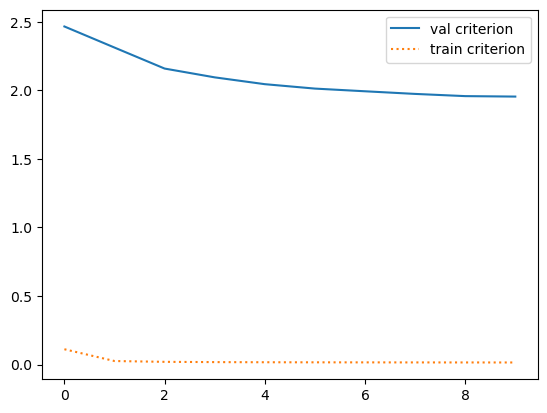

In [13]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

In [14]:
load_data_kwargs={'train_loader_kwargs' : {'batch_size' : 512,      #training batch size
                                           'subsample_rate' : 1,   #subsample rate which defines a fraction of data that is used when sampling. 1 means all data is used
                                           'subsample_seed' : 42,   #seed for the subsampling
                                           'seed' : 42,             #seed for the random number generator
                                           'shuffle' : True},       #shuffle the training set
                    'val_loader_kwargs' : {'batch_size' : 512,        #validation batch size
                                           'subsample_rate' : 1, 
                                           'subsample_seed' : 42, 
                                           'shuffle' : False}}      # we don't need to shuffle the validation set

In [15]:
import copy  # because configurations are a dictionary we must use deepcopy to avoid changing the original configuration
config = copy.deepcopy(trainer.config)
config['run'] = 'nosubsample'
config['load_data_kwargs'] = load_data_kwargs

In [16]:
trainer.fit(config=config)

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:21:13,925 | WARNING | src.trainers  | 	 ============Updating the config with the new config============
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:21:13,926 | INFO | src.trainers  | 	 Comprehending the configuration settings
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:21:13,927 | WARNING | src.trainers  | 	 Creating new model. Note this will replace any previous model
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:21:13,938 | INFO | src.models  | 	 CUDA available: False
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:21:13,940 | INFO | src.models  | 	 Initialized model: MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=80, bias=True)
    (3): Tanh()
    (4)

inf

In [17]:
! ls {work_dir}
! ls {work_dir}/nosubsample # the sub-folder contains the corresponding model, its own configuration and the training logs (run.log) specific to this run. The loss history is stored in loss_dict.pkl

config.json  loss_dict.pkl  model.pth  nosubsample  training.log  X.pkl  y.pkl
config.json  loss_dict.pkl  model.pth


In [18]:
print(f"work directory: {trainer.work_dir}")
print(f"{trainer.run = }")

work directory: /volume1/scratch/georgem/closure/models/dev/dev17/
trainer.run = 'nosubsample'


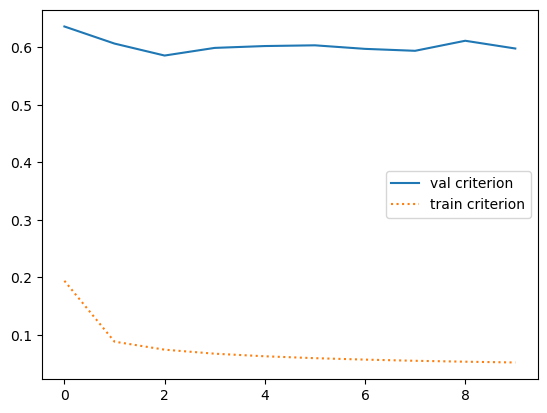

In [19]:
import matplotlib.pyplot as plt
for key, val_loss in trainer.model.val_loss_.items():
    plt.plot(val_loss, label=f'val {key}')
for key, val_loss in trainer.model.train_loss_.items():
    plt.plot(val_loss, label=f'train {key}', linestyle=':')
#plt.ylim(0, 8e-1)
plt.legend()
plt.show()

In [20]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)

The function pred_ground_targets is deprecated. Use transform_targets instead.
Total loss 0.5987088084220886
Loss for channel 0:  Pxx_e, loss = 0.12249289453029633
Loss for channel 1:  Pyy_e, loss = 0.1507275253534317
Loss for channel 2:  Pzz_e, loss = 0.18007250130176544
Loss for channel 3:  Pxy_e, loss = 1.0964057445526123
Loss for channel 4:  Pxz_e, loss = 1.2965642213821411
Loss for channel 5:  Pyz_e, loss = 0.7459897994995117


invfunc = <ufunc 'exp'>


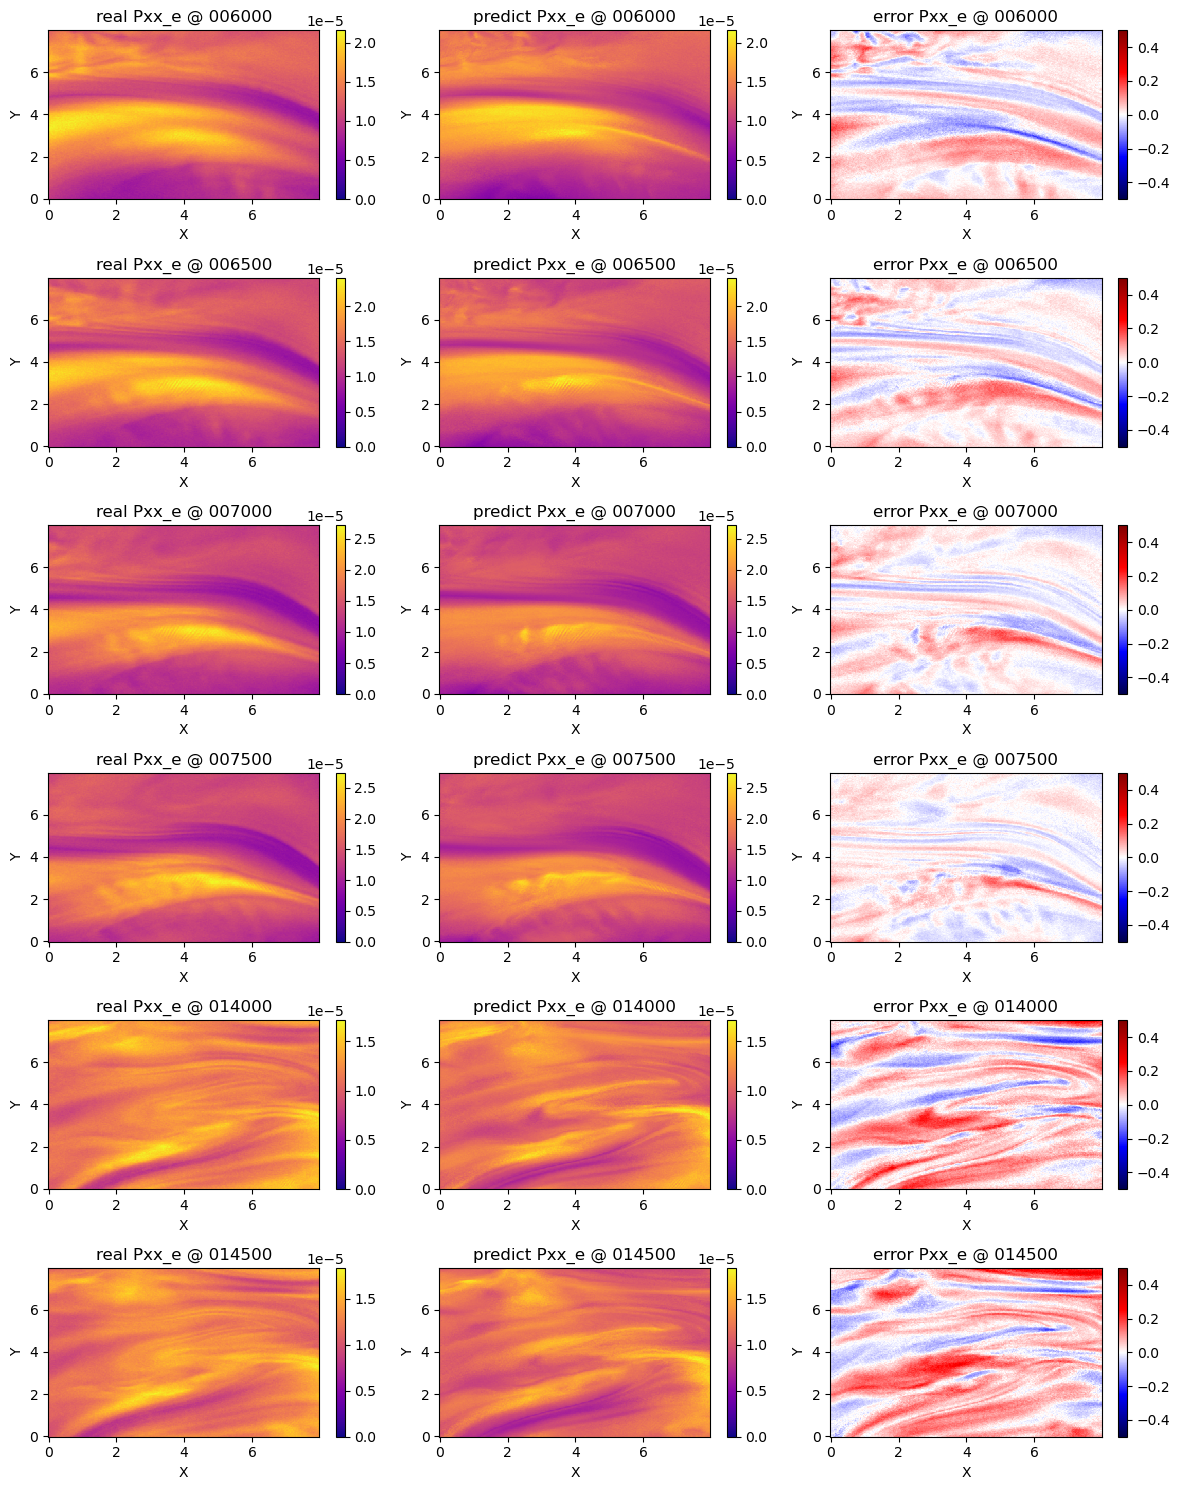

In [21]:
tr.ut.plot_pred_targets(trainer, 'Pxx_e', prediction, ground_truth, list_of_target_indices, figsize=(12,15))

In [22]:
trainer.load_run(f"./") # load the run which is in the parent directory (runs are always defined relative to the work_dir)

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:22,915 | INFO | src.trainers  | 	 ==========Config file /volume1/scratch/georgem/closure/models/dev/dev17/./config.json found, logging to /volume1/scratch/georgem/closure/models/dev/dev17//.//run.log========
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:22,916 | WARNING | src.trainers  | 	 Loading configuration based on it and the associated model weights/training loss!
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:22,917 | INFO | src.trainers  | 	 Comprehending the configuration settings
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:22,917 | WARNING | src.trainers  | 	 Creating new model. Note this will replace any previous model
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:22,925 | INFO | src.models  | 	 CUDA available: False
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 1

In [23]:
prediction, ground_truth, list_of_target_indices = tr.ut.pred_ground_targets(trainer)

The function pred_ground_targets is deprecated. Use transform_targets instead.


Total loss 1.6426488161087036
Loss for channel 0:  Pxx_e, loss = 1.1722993850708008
Loss for channel 1:  Pyy_e, loss = 1.0672461986541748
Loss for channel 2:  Pzz_e, loss = 1.7456531524658203
Loss for channel 3:  Pxy_e, loss = 2.2462775707244873
Loss for channel 4:  Pxz_e, loss = 2.0850164890289307
Loss for channel 5:  Pyz_e, loss = 1.5394002199172974


## Trying CNN

In [24]:
dataset_kwargs = {'data_folder': "/volume1/scratch/share_dir/ecsim/",               # where the data is stored
                          'image_file_name_column' : 'filenames',                       # the column in the csv file that contains the image file names
                          'read_features_targets_kwargs' : read_features_targets_kwargs,
                          'train_sample' :  "/volume1/scratch/share_dir/brecht/sampling/turbulence/train.csv",  # this should be the path to the csv file that contains a list of training samples, each cell corresponds to local paths to the actual data relative to `data_folder`
                          'val_sample' :    "/volume1/scratch/share_dir/brecht/sampling/turbulence/val.csv",    # same but validation
                          'test_sample' :   "/volume1/scratch/share_dir/brecht/sampling/turbulence/test.csv",   # same but testing
                          'scaler_features' : True,    # Whether to normalize the features. It is called scaler because it rescales to 0 mean and 1 variance
                          'scaler_targets' : True,     # Whether to normalize the targets
                          'flatten' : False,  # Whether to flatten the features and targets before training. If False, the features and targets are kept as they are
                          'prescaler_targets' : ['log','log','log',None,None,None]  # If we want to transform the targets before training. The order in which they appear correspond to `request_targets` in `read_features_targets_kwargs``
                      }

In [25]:
load_data_kwargs={
        "train_loader_kwargs": {
            "batch_size": 32,
            "patch_dim": [32,32],
            "subsample_rate": 160,
            "subsample_seed": 42,
            "seed": 42,
            "shuffle": True
        },
        "val_loader_kwargs": {
            "batch_size": 32,
            "patch_dim": [32,32],
            "subsample_rate": 160,
            "subsample_seed": 42,
            "shuffle": False
        }
    }

In [26]:
model_kwargs = {"model": "FCNN",
        "model_seed": 42,
        "channels": [10,128,64,6],
        "activations": [ "ReLU","ReLU","ReLU", "ReLU", None],
        "kernels": [5,5,3,3],
        "batch_norms": [True,True,True,False],
        "optimizer_kwargs": {
            "optimizer": "Adam",
            "lr": 0.001,
            "weight_decay": 1e-05,
            "criterion": "MSELoss"
        },
        "scheduler_kwargs": {
            "scheduler": "ReduceLROnPlateau",
            "mode": "min",
            "factor": 0.2,
            "patience": 25,
            "epochs": 2,
            "min_lr": 1e-05,
            "early_stopping": 100
        },
        "logger_kwargs": {
            "update_step": 1,
            "show": True
        }
    }

In [27]:
work_dir = '/volume1/scratch/georgem/closure/models/dev/dev18/'  # you may have to create containing path before running the script (check in the source code). It is better to use absolute paths than relative paths for the operations below to work
                                                                            # the /dev16/ folder on the other hand will be definitely created by the trainer so you don't need to create it
! rm -rf {work_dir}  # This will delete the previously existing model
trainer2 = tr.Trainer(work_dir=work_dir,   # where the model will be saved
                     dataset_kwargs=dataset_kwargs, load_data_kwargs=load_data_kwargs, model_kwargs=model_kwargs)

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:25,445 | INFO | src.trainers  | 	 Creating a new configuration file: /volume1/scratch/georgem/closure/models/dev/dev18/config.json
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:25,446 | INFO | src.datasets  | 	  This is train set
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:25,446 | INFO | src.datasets  | 	 Loading data split from: /volume1/scratch/share_dir/brecht/sampling/turbulence/train.csv
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:45,030 | INFO | src.datasets  | 	 Data shape - Features: (16, 10, 256, 256), Targets: (16, 6, 256, 256)
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:24:45,082 | INFO | src.datasets  | 	 Computed and saved normalization parameters for features to /volume1/scratch/georgem/closure/models/dev/dev18//X.pkl
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-

In [28]:
trainer2.fit()

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:25:39,833 | INFO | src.trainers  | 	 Prior to fit: RAM memory % used: 7.1, RAM Used (GB): 17.055174656, process RAM usage (GB): 1.2760734558105469
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:25:39,834 | INFO | src.models  | 	 Each forward pass had 80 train batches.
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:25:42,522 | INFO | src.models  | 	 Number of samples per batch: len(next(iter(train_loader))[0]) = 32
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:25:50,919 | INFO | src.models  | 	 Epoch 1/2 | Train loss: 5.9433e-01 | Val loss: 9.5363e-01 | Time/epoch: 8.396 s | Time/epoch_train: 5.266 s | Learn rate: [0.001]
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:25:59,587 | INFO | src.models  | 	 Epoch 2/2 | Train loss: 4.1582e-01 | Val loss: 8.5664e-01 | Time/epoch: 8.666 s | Time/epoch_train: 5.105 s | Learn 

inf

In [29]:
ut = tr.ut #this has the same effect as import src.utilities as ut, because we imported src.trainers as tr and in src.trainers we imported src.utilities as ut
loss = ut.compare_metrics(work_dirs=[ work_dir,work_dir], runs=['./','nosubsample'], metric=['r2'])

 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:26:01,890 | WARNING | src.trainers  | 	 Config file /volume1/scratch/georgem/closure/models/dev/dev18/config.json found -> loading configuration
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:26:01,891 | INFO | src.datasets  | 	  This is train set
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:26:01,892 | INFO | src.datasets  | 	 Loading data split from: /volume1/scratch/share_dir/brecht/sampling/turbulence/train.csv
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:26:22,032 | INFO | src.datasets  | 	 Data shape - Features: (16, 10, 256, 256), Targets: (16, 6, 256, 256)
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025-07-15 14:26:22,034 | INFO | src.datasets  | 	 Loaded normalization parameters for features from /volume1/scratch/georgem/closure/models/dev/dev18//X.pkl
 | haydn.esat.kuleuven.be | @rank: None | @local: None at 2025

FileNotFoundError: Config file /volume1/scratch/georgem/closure/models/dev/dev18/nosubsample/config.json not found.

In [25]:
loss

,work_dir,exp,run,total_loss,total_r2,Pxx_e,Pxx_e_r2,Pyy_e,Pyy_e_r2,Pzz_e,Pzz_e_r2,Pxy_e,Pxy_e_r2,Pxz_e,Pxz_e_r2,Pyz_e,Pyz_e_r2
0,/volume1/scratch/georgem/closure/models/dev/de...,dev17,./,1.6426488,-1.3390856,1.1722994,-2.727578,1.0672462,-3.6904984,1.7456532,-15.257868,2.2462776,-3.6283722,2.0850165,-0.7095127,1.5394002,-0.54140663
1,/volume1/scratch/georgem/closure/models/dev/de...,dev17,nosubsample,0.5987088,0.2032277,0.122492895,0.7662746,0.15072753,0.7289284,0.1800725,0.6876477,1.0964057,-0.37125993,1.2965642,-0.5445119,0.7459898,0.12824869


In [2]:
loss2 = loss.copy()
loss2['work_dir'] = loss2['work_dir'].str.split('/').str[-1]
loss2['work_dir'].iloc[0] = 'subsample'
loss2['work_dir'].iloc[1] = 'full'
print(loss2.to_string(index=False))

NameError: name 'loss' is not defined

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
selected_columns = loss2.columns[~loss2.columns.str.endswith('_r2')]
selected_data = loss2[selected_columns]
columns = selected_data.columns[loss2.columns.get_loc('total_loss'):]

x = list(loss2['work_dir'])
df = pd.DataFrame({key: value for key, value in zip(columns, loss2[columns].values.T.tolist())}, index=list(x), 
                  dtype=float)
fig = plt.figure(figsize=(15, 5)) 
df.plot.bar(rot=90, ax=fig.gca())
plt.ylim([0,2])
plt.ylabel('Mean Square Error')
plt.xlabel('experiments')

NameError: name 'loss2' is not defined

In [1]:
columns_r2 = loss2.columns[loss2.columns.str.endswith('_r2')]
#selected_data_r2 = loss2[selected_columns_r2]
#columns_r2 = selected_data_r2.columns[loss2.columns.get_loc('total_r2'):]
x = list(loss2['work_dir'])

df = pd.DataFrame({key: value for key, value in zip(columns_r2, loss2[columns_r2].values.T.tolist())}, index=list(x), 
                  dtype=float)
fig = plt.figure(figsize=(15, 5)) 
df.plot.bar(rot=90, ax=fig.gca())
plt.ylim([-1,1])
plt.ylabel(r'$R^2$ score')
plt.xlabel('experiments')

NameError: name 'loss2' is not defined

In [30]:
import sys
sys.path.append('../')
import src.trainers as tr
work_dir = '/volume1/scratch/georgem/closure/models/dev/dev17/' 
trainer = tr.Trainer(work_dir=work_dir)
trainer.load_run(f'./nosubsample') # load the run which is in the parent directory (runs are always defined relative to the work_dir)

2025-07-15 10:30:34,154 - src.trainers - WARNING - Config file /volume1/scratch/georgem/closure/models/dev/dev17/config.json found -> loading configuration
2025-07-15 10:30:34,155 - src.datasets - INFO -  This is train set
2025-07-15 10:30:34,155 - src.datasets - INFO - Loading data split from: /volume1/scratch/share_dir/brecht/sampling/turbulence/train.csv
2025-07-15 10:30:53,658 - src.datasets - INFO - Data shape - Features: (1048576, 10), Targets: (1048576, 6)
2025-07-15 10:30:53,659 - src.datasets - INFO - Loaded normalization parameters for features from /volume1/scratch/georgem/closure/models/dev/dev17//X.pkl
2025-07-15 10:30:53,660 - src.datasets - INFO - Applying normalization to features
2025-07-15 10:30:53,727 - src.datasets - INFO - Applied log to targets channel 0
2025-07-15 10:30:53,734 - src.datasets - INFO - Applied log to targets channel 1
2025-07-15 10:30:53,739 - src.datasets - INFO - Applied log to targets channel 2
2025-07-15 10:30:53,740 - src.datasets - INFO - Loa